In [36]:
import anndata as ad
import scanpy as sc
from sklearn.model_selection import train_test_split
import pylab as pl
import seaborn as sns
from limix_core.util.preprocess import gaussianize, regressOut
import scipy.stats as st

from sklearn.impute import SimpleImputer
import scipy.linalg as la
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from os.path import join
from mtgwas import VCTEST
from mtgwas.utils import df_match

In [2]:
%load_ext autoreload
%autoreload 2

In [37]:
tissue = 'Organoid'
outdir = f'visualization/{tissue}'
os.makedirs(outdir, exist_ok=True)

In [38]:
#Reading the anndata
hfile = f"../../organoid_anndata.h5ad"
idata = ad.read_h5ad(hfile)

/Users/dennyal/miniforge3/envs/tcf7l2/lib/python3.13/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
idata.obs_names = idata.obs["SampleBarcode"]

/Users/dennyal/miniforge3/envs/tcf7l2/lib/python3.13/site-packages/anndata/_core/anndata.py:812: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['AS0033-02-MMR-001', 'AS0033-02-MMR-001', 'AS0051-03-MCS-001', 'AS0051-03-MCS-001', 'AS0009-03-MCS-007']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")


In [41]:
bool_series = idata.obs['Day'] == 15

In [44]:
idata.var

,Category,Formula,Package_Library,Explanation,performed_by_channel
Feature Name,,,,,
MinDiameter_shape,Shape,"min(bbox[2]-bbox[0],bbox[3]-bbox[1])",skimage.measure.regionprops().bbox,Shortest diameter from center point of segment...,Yes
MaxDiameter_shape,Shape,"max(bbox[2]-bbox[0],bbox[3]-bbox[1])",skimage.measure.regionprops().bbox,Longest diameter from center point of segmente...,Yes
MeanDiameter_shape,Shape,"mean(bbox[2]-bbox[0],bbox[3]-bbox[1])",skimage.measure.regionprops().bbox,Mean diameter from center point of segmented o...,Yes
Area_shape,Shape,sum(foreground_mask),NaN,Area of segmented object,Yes
Perimeter_shape,Shape,sum(foreground_mask-erode(foreground_mask),NaN,Perimeter of segmented object,Yes
...,...,...,...,...,...
Solidity_halo,Shape,sum(foreround_mask) / foreground_mask.convex_area,skimage.measure.regionprops().convex_area,Ratio of the area to the area of its convex hu...,NaN
Extent_halo,Shape,sum(foreround_mask)/ROI^2,NaN,"Ratio between segmented area and total area. ""...",NaN
Eccentricity_halo,Shape,focal_distance/Major_axis,skimage.measure.regionprops().eccentricity,measure of how elongated or stretched out the ...,NaN


In [46]:
day15 = ad.AnnData(X = idata.X[bool_series], obs = idata.obs[bool_series], var = idata.var)

/Users/dennyal/miniforge3/envs/tcf7l2/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [49]:
day15.obs_names

CategoricalIndex(['AS0033-02-MMR-001', 'AS0033-02-MMR-001',
                  'AS0051-03-MCS-001', 'AS0051-03-MCS-001',
                  'AS0009-03-MCS-007', 'AS0009-03-MCS-007',
                  'AS0009-02-MCS-004', 'AS0009-02-MCS-004',
                  'AS0009-02-MCS-001', 'AS0009-02-MCS-001',
                  ...
                  'AS0051-03-MCS-006', 'AS0051-03-MCS-006',
                  'AS0009-03-MCS-009', 'AS0009-03-MCS-009',
                  'AS0051-03-MCS-008', 'AS0051-03-MCS-008',
                  'AS0033-03-MCS-007', 'AS0033-03-MCS-007',
                  'AS0051-03-MCS-004', 'AS0051-03-MCS-004'],
                 categories=['AS0009-02-MCS-001', 'AS0009-02-MCS-002', 'AS0009-02-MCS-003', 'AS0009-02-MCS-004', ..., 'AS0051-03-MCS-007', 'AS0051-03-MCS-008', 'AS0051-03-MCS-009', 'AS0051-03-MCS-010'], ordered=False, dtype='category', name='SampleBarcode', length=1967)

In [50]:
dfX = day15.to_df()


In [51]:
dfX

Feature Name,MinDiameter_shape,MaxDiameter_shape,MeanDiameter_shape,Area_shape,Perimeter_shape,MinDiameter_um_shape,MaxDiameter_um_shape,MeanDiameter_um_shape,Area_um^2_shape,Perimeter_um_shape,...,MinDiameter_um_halo,MaxDiameter_um_halo,MeanDiameter_um_halo,Perimeter_um_halo,FormFactor_halo,Solidity_halo,Extent_halo,Eccentricity_halo,Orientation_halo,Compactness_halo
SampleBarcode,,,,,,,,,,,,,,,,,,,,,
AS0033-02-MMR-001,0.520878,0.433109,0.709029,0.709338,0.327039,0.520878,0.433109,0.709029,0.709338,0.327039,...,0.314770,-0.330565,-0.226379,0.070230,-0.127158,1.283026,1.412328,0.312651,-1.423442,-0.138114
AS0033-02-MMR-001,0.836560,0.922248,1.006546,1.112185,1.550153,0.836560,0.922248,1.006546,1.112185,1.550153,...,-0.487119,-1.121732,0.256658,-1.325919,1.638095,0.573387,1.208908,-0.752491,0.077187,-0.102638
AS0051-03-MCS-001,-0.403618,-0.235862,-0.144566,-0.302704,-0.360849,-0.403618,-0.235862,-0.144565,-0.302704,-0.360849,...,-1.146448,1.035997,-1.018117,2.332759,-0.888060,1.344738,0.668574,1.410038,-1.589472,-0.156494
AS0051-03-MCS-001,0.265326,-0.020065,0.206650,0.087893,-0.080454,0.265326,-0.020065,0.206651,0.087893,-0.080454,...,-0.380200,-0.762111,-0.720419,1.329080,-0.766378,0.572472,1.180282,0.025405,-1.300089,-0.123582
AS0009-03-MCS-007,-0.148066,-0.163930,0.063650,-0.075499,-0.248302,-0.148066,-0.163930,0.063650,-0.075498,-0.248302,...,-0.344561,-0.600282,-0.091268,0.280481,-0.239514,1.387975,1.818397,0.064116,-1.300214,-0.141107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AS0051-03-MCS-008,-1.162756,-1.386779,-1.126973,-1.203588,-1.104778,-1.162756,-1.386779,-1.126973,-1.203588,-1.104778,...,-0.968251,-1.499336,-2.473577,-0.131584,0.032257,2.461368,2.620802,-0.155343,-1.184953,-0.159913
AS0033-03-MCS-007,0.257810,0.008708,0.251013,0.139796,-0.089872,0.257810,0.008708,0.251013,0.139796,-0.089872,...,-1.787959,-1.625203,-2.194857,-0.750820,0.560850,2.150288,2.028558,0.057040,1.054165,-0.138969
AS0033-03-MCS-007,0.227745,-0.106384,0.187653,0.065842,-0.142992,0.227745,-0.106384,0.187653,0.065842,-0.142992,...,-0.380200,-0.798073,-0.193999,0.307482,-0.341737,0.976727,1.484662,-1.301677,1.348116,-0.127001


In [52]:
dfX = dfX.groupby(["SampleBarcode"]).mean()
dfX = dfX.dropna()

/var/folders/mr/zvvy4g790mz914r9cm23_92rl3zggr/T/ipykernel_54964/3369822987.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfX = dfX.groupby(["SampleBarcode"]).mean()


In [68]:
# Simulate a trait to visualize its direction
# snp_df = pd.DataFrame(np.random.rand(dfX.shape[0], 1))
# snp_df.index = dfX.index
trait = "MaxDiameter_shape"
snp_df = pd.DataFrame(np.asarray(dfX[trait]))
snp_df.index = dfX.index


In [69]:
X = dfX.values
y = snp_df.values
F = np.zeros((dfX.shape[0], 1))

In [70]:
#regressing out the covariates from the embeddings
yr = regressOut(y, F)
Xr = regressOut(X, F)

In [71]:
Xr

array([[ 0.7363432 ,  0.7624988 ,  0.54725903, ..., -0.40141645,
        -0.57755202, -0.11601288],
       [ 0.44759491,  0.42726418,  0.19175881, ..., -0.51792097,
        -0.53800517, -0.12064335],
       [ 0.216471  ,  0.23889144, -0.00213822, ..., -0.36413914,
        -0.18895923, -0.12680902],
       ...,
       [-0.54469126, -0.60714328, -0.718741  , ..., -0.19749326,
        -0.61978632, -0.13372514],
       [ 0.33748224,  0.35254449,  0.39159864, ..., -0.28572339,
        -0.30229127, -0.11239754],
       [ 0.07037437,  0.00151479, -0.12272169, ..., -0.39809766,
         0.15219113, -0.1295125 ]], shape=(53, 171))

In [72]:
# fit variant component model
vc = VCTEST()
res = vc.fit(Xr, yr)
ystar = vc.predict_loo()

100%|██████████| 100/100 [00:00<00:00, 10109.19it/s]


In [74]:
# getting direction for each of the images
day15.obs['ystar'] = vc.predict(day15.X).ravel()

# Working on PGAN for interpolation

### Note below interpolation was done on simulated trait

In [75]:
import sys

from torchvision.utils import make_grid
import json
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
import torch
os.chdir('..')
from models.progressive_gan import ProgressiveGAN as PGAN

In [83]:
class Generator():
    
    def __init__(self, config, checkpoint, useGPU=True):
        with open(config, 'rb') as file:
            config = json.load(file)
        self.pgan = PGAN(useGPU=useGPU, storeAVG=True, **config)
        self.pgan.load(checkpoint)
        self.netG = self.pgan.netG
        self.device = self.pgan.device
        
    def forward(self, x, eps=None):
        if eps is None:
            eps = torch.randn(x.shape[0], 512)
        if type(x)==np.ndarray:
            x = torch.Tensor(x)
        if type(eps)==np.ndarray:
            eps = torch.Tensor(eps)
        x = x.to(self.device)
        eps = eps.to(self.device)
        with torch.no_grad():
            out = self.netG(eps, x).data.cpu()
            out = 0.5 * (out + 1)
            out = torch.clip(out, 0, 1)
        return out
    
def load_image_torch(path, size):
    if type(path) in [list, np.ndarray]:
        return torch.cat([load_image_torch(_, size) for _ in path])
    return pil_to_tensor(Image.open(path).resize((size, size)))[None] / 255.


def torch_imshow(x):
    pl.imshow(x.permute(1, 2, 0))

In [85]:
config = '/Users/dennyal/Desktop/repos/HistoGWAS_PGAN/PGAN/config/config_OrganoidLocal.json'
checkpoint = '/Users/dennyal/Desktop/Organoid/Organoid_s6_i736000.pt'
generator = Generator(config, checkpoint, useGPU=True)

here False
Average network found !


In [86]:
# Getting the top and the bottom embedding to be used for interpolation

outliers = 0.01
extreme = 0.05
q1, q2, Q1, Q2 = np.quantile(day15.obs['ystar'].values, [outliers, extreme, 1 - extreme, 1 - outliers])
Ih1 = np.logical_and(day15.obs['ystar'].values>Q1, day15.obs['ystar'].values<Q2)
Il1 = np.logical_and(day15.obs['ystar'].values>q1, day15.obs['ystar'].values<q2)

# interpolates
emb1 = day15.X[Il1].mean(0)[None]
emb2 = day15.X[Ih1].mean(0)[None]

In [87]:
emb1

array([[-1.4466604 , -1.5614196 , -1.4644829 , -1.4041919 , -1.2572509 ,
        -1.4466605 , -1.5614196 , -1.464483  , -1.404192  , -1.2572509 ,
         0.15637259, -0.14193627,  0.08261984, -0.26571238, -0.28139257,
         0.3581736 ,  1.4534898 , -1.3870921 ,  0.518251  , -1.383531  ,
         1.4046409 ,  1.4055437 ,  1.4539435 , -1.3895091 ,  0.4984288 ,
        -1.3856733 ,  1.4049541 ,  1.4058229 ,  1.4539225 , -1.3885907 ,
         0.5602774 , -1.384778  ,  1.4050171 ,  1.4058506 ,  1.4534898 ,
        -1.3870921 ,  0.518251  , -1.383531  ,  1.4046409 ,  1.4055437 ,
         1.4551222 , -1.3980759 ,  0.2674009 , -1.3940593 ,  1.4059606 ,
         1.4066571 ,  1.4563897 , -1.402324  ,  0.26539057, -1.3977519 ,
         1.4069847 ,  1.4075185 ,  1.4564797 , -1.4031382 ,  0.2976935 ,
        -1.3982748 ,  1.4070274 ,  1.4075572 ,  1.4551222 , -1.3980759 ,
         0.2674009 , -1.3940593 ,  1.4059606 ,  1.4066571 ,  1.4568529 ,
        -1.4039683 ,  0.05862007, -1.3994515 ,  1.4

In [88]:
emb1.shape

(1, 171)

In [ ]:
os.chdir("/Users/dennyal/Desktop/repos/HistoGWAS_PGAN/PGAN/Notebooks")
for i in range(1):   # This are different realization of the same embedding
    inter = np.linspace(0, 1, 8)[:, None]
    Embs = emb1 * (1 - inter) + emb2 * inter
    print(np.ones([Embs.shape[0], 1]).shape)
    Eps = np.random.randn(1, 512) * np.ones([Embs.shape[0], 1])
    print(Eps.shape)
    Xinter = generator.forward(Embs, Eps)
    print("here",Xinter.shape)
    
    outdir_temp = join(outdir, f'realization_{i}')
    os.makedirs(outdir_temp, exist_ok=True)
    images = []
    for idx,img in enumerate(Xinter):
        print(idx)
        print(img.shape)
        img = to_pil_image(img)
        outfile = join(outdir_temp, f'{idx}_{tissue}.PNG')
        
        images.append(img)
    images_forward = images
    images_backward = images[::-1]  # Reverse the order of frames

    looped_frames = images_forward + images_backward[1:]
    
    
    os.makedirs(outdir, exist_ok=True)
    gif_file = f"{tissue}_interpolation_Day15__{trait}{i}.gif"
    outfile = join(outdir, gif_file)
    looped_frames[0].save(outfile, save_all=True, append_images=looped_frames[1:], loop=0)

  
    
Xinter_grid = make_grid(Xinter, nrow=8)

(8, 1)
(8, 512)
here torch.Size([8, 1, 256, 256])
0
torch.Size([1, 256, 256])
1
torch.Size([1, 256, 256])
2
torch.Size([1, 256, 256])
3
torch.Size([1, 256, 256])
4
torch.Size([1, 256, 256])
5
torch.Size([1, 256, 256])
6
torch.Size([1, 256, 256])
7
torch.Size([1, 256, 256])


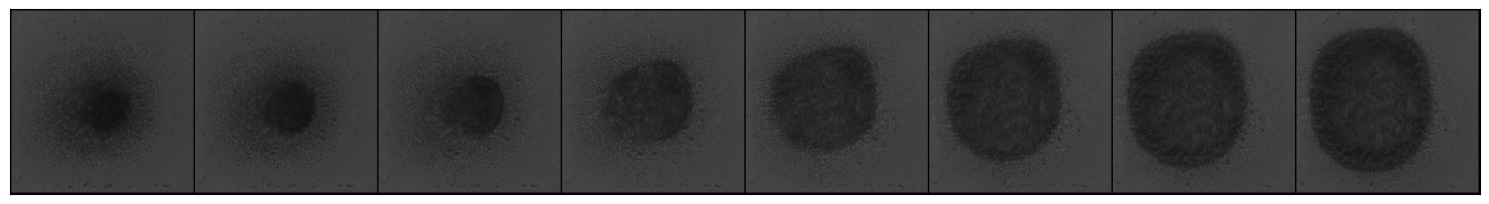

In [90]:
# Doing the projection
pl.figure(1, figsize=(15, 15))
plt = pl.subplot(111)
torch_imshow(Xinter_grid)
plt.set_xticks([])
plt.set_yticks([])
pl.tight_layout()
#pl.savefig(f'{figdir}/randomsamples.png', dpi=300)